<a href="https://colab.research.google.com/github/DavideScassola/SML_midi_autoencoder/blob/main/Epic_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypianoroll # for generating MIDI files
!pip install pygame # for listening pieces (works only in local)

     |████████████████████████████████| 5.6MB 14.0MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=b897425be709e17aa43823f465830918f3274df3bd8c2b76a8f9b29dad2343d7
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi
     |████████████████████████████████| 11.5MB 13.5MB/s 


In [ ]:
import random as rararandom
from google.colab import drive
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

  
beat_len = 24
notes_range = 70


def load_data(file = "./drive/My Drive/music.pk"):
  drive.mount('/content/drive')

  # This will take same minutes
  with open(file, "rb") as f:
      music_original = pickle.load(f)
      
  return music_original
  

def slice_pieces_old(xy_dataset_raw, slice_len):
  print("\nSlicing . . .")
  xy_dataset_out = []

  for j in xy_dataset_raw:
    p = j

    n_slices  = (p["piece"].get_shape()[0])//slice_len
    slices = [p["piece"][slice_len*i:slice_len*(i+1)] for i in range(n_slices)]

    couples = list(zip(slices, [p['one_hot_composer']]*n_slices))
    xy_dataset_out = xy_dataset_out + couples
  return xy_dataset_out


def slice_pieces(xy_dataset_raw, slice_len, offset = 0):
  print("\nSlicing . . .")
  xy_dataset_out = []

  for j in xy_dataset_raw:
    p = j

    n_slices  = (p["piece"].get_shape()[0])//slice_len - 1
    slices = [p["piece"][slice_len*i+offset:slice_len*(i+1)+offset] for i in range(n_slices)]

    couples = list(zip(slices, [p['one_hot_composer']]*n_slices))
    xy_dataset_out = xy_dataset_out + couples
    
  return xy_dataset_out
  
  
def preprocess_data(music_original, discretize = False, filtered_composers = None,
                    test_proportion = 0, validation_proportion = 0.1, slice_bars = 8):
  
  """
  normalization
  """
  print("Normalization . . .")
  for m in music_original:
    m["piece"] = m["piece"].tocsr()
    m["piece"] = m["piece"].astype(np.float16)
    if(discretize):
      m["piece"] = (m["piece"] > 0)+0
    else:
      m["piece"] = m["piece"]/m["piece"].max()
  

  """
  Shrinking the notes range
  """
  columns_to_keep = list(range(26,96))
  for m in music_original:
      m["piece"] = (m["piece"])[:,columns_to_keep]
    
    
    
  """
  See all composers
  """

  from collections import Counter

  # this will count the number of pieces for each composer in the random sample
  c = Counter([i["composer"] for i in music_original]).items()

  # list of all composers
  composers = [item[0] for item in c]
  n_composers =  len(composers)

  print(c)



  """
  remove some composers
  """

  if(filtered_composers == None):
    music = music_original
    
  else:
    composers = filtered_composers
    music = [m for m in music_original if m["composer"] in composers]
    n_composers =  len(composers)
    Counter([i["composer"] for i in music]).items()
  

  """
  One hot encoding and create labels
  """
  print("One hot encoding . . .")
  def encode_composer(name):
    encoding = np.zeros((n_composers))
    encoding[composers.index(name)] = 1
    return encoding

  def decode_composer(ohe):
    return composers[np.argmax(ohe)]

  for m in music:
    m['one_hot_composer'] = encode_composer(m['composer'])


  """
  split train set and test set (randomic)
  """

  train_proportion = 1-test_proportion

  total_size = len(music)
  train_size = int(total_size * train_proportion)
  validation_size = int(train_size*validation_proportion)

  rararandom.Random(1996).shuffle(music)

  xy_validation_raw = music[0:validation_size]
  xy_train_raw = music[validation_size:train_size]
  xy_test_raw = music[train_size:]
  
  
  """
  slice the pieces (same length)
  """
  notes_range = 70
  beat_len = 24

  slice_len = beat_len*slice_bars*4

  xy_validation = slice_pieces(xy_validation_raw, slice_len)
  xy_train = slice_pieces(xy_train_raw, slice_len)
  xy_test = slice_pieces(xy_test_raw, slice_len)
  
  
  """
  Dividing x and y
  """
    
  x_validation = [e[0] for e in xy_validation]
  y_validation = [e[1] for e in xy_validation]

  x_train = [e[0] for e in xy_train]
  y_train = [e[1] for e in xy_train]

  x_test = [e[0] for e in xy_test]
  y_test = [e[1] for e in xy_test]
  
  print("slice shape is:", x_train[0].shape, "bars: ", slice_len/(4*24))
  print("there are %d slices in the train set" % len(x_train))
  print("there are %d slices in the validation set" % len(x_validation))
  print("and %d slices in the test set" % len(x_test))
  
  return (composers, x_train, y_train, x_validation, y_validation, x_test, y_test, xy_train_raw)
  
  
  
def batch_generator(X_data, batch_size, discretize = False):
  nb_batches = len(X_data)//batch_size
  sl = X_data[0].shape[0]
  counter = 0
  epochs = 0
  
  while True:
    #print("counter: ", counter, nb_batches)
    if(counter == nb_batches):
      epochs += 1 
      counter = 0
      rararandom.shuffle(X_data)
      #X_data = periodical_slicing(train_raw = xy_train_raw, offset_beats = ((epochs%3)*4))
      
    batch_X = []
    for i in range(counter*batch_size, (counter+1)*batch_size):
      if(discretize):
        batch_X.append( ((X_data[i]>0)+0).todense())
      else:
        batch_X.append( X_data[i].todense())
    counter = (counter + 1)
    batch_X = np.array(batch_X)
    if(discretize):
      batch_X = (batch_X>0)+0
      
    yield( batch_X, batch_X )
    
    
    
from random import randrange


def random_slice_batch_generator(Xy_data, batch_size = 32, discretize = False, penalization = 0, shift_a_bar = False):
  
  curr_Xy_data = slice_pieces(Xy_data, slice_len, offset = 0)
  X_data = [e[0] for e in curr_Xy_data]

  
  nb_batches = len(X_data)//batch_size
  counter = 0
  epochs = 0
  
  while True:
    if(counter == nb_batches):
      if(shift_a_bar):
        offset = randrange(slice_len//(96))*96 # Random integer offset.
      else:
        offset = randrange(slice_len//12)*12 # Random integer offset.
      curr_Xy_data = slice_pieces(Xy_data, slice_len, offset)
      X_data = [e[0] for e in curr_Xy_data]
      epochs += 1 
      counter = 0
      rararandom.Random(epochs).shuffle(X_data)
      
    batch_X = []
    for i in range(counter*batch_size, (counter+1)*batch_size):
      batch_X.append( X_data[i].todense() )
    counter = (counter + 1)
    batch_X = np.array(batch_X)
    if(discretize):
      batch_X = (batch_X>0)+0
    if(penalization>0):
      batch_X += (batch_X==0)*(-penalization)
    yield( batch_X, batch_X )
    
    
    
    
    
def compile_and_fit(model, train_data,val_data, epochs, batch_size, loss, metrics, optimizer, path, save = False, load = False, augmentation = None, discretize = False, penalization=0, shift_a_bar = False):
  
  model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
  
  if(load):
    model.load_weights(path)
  
  checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  call = []
  
  if(save):
    call = [checkpoint]
    
  print(model.summary())
  
  my_generation = None
  
  if(augmentation!=None):
    my_generation = random_slice_batch_generator(augmentation, batch_size , discretize, penalization, shift_a_bar)
  else:
    my_generation=batch_generator(train_data, batch_size, penalization)
    
  steps = len(train_data)//batch_size
  if(augmentation!=None):
    steps = steps
    
  
  history = model.fit_generator(generator=my_generation,
                      nb_epoch=epochs, steps_per_epoch=steps,
                      validation_data = batch_generator(val_data, batch_size, discretize),
                      validation_steps=len(val_data)//batch_size, callbacks = call)
  
  return history
    
    
    
    
    
    
    
    
    
"""
This code is just for writing down MIDI files and if you are in local, listen to them
"""


% pylab inline
from pypianoroll import Multitrack, Track
import pygame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

def write_midi(arr, filename):
    Multitrack(tracks=[Track(arr*127)]).write(filename)
    
def write_cutted_midi(arr, filename):
    x = np.zeros((arr.shape[0],128))
    x[:,list(range(26,96))] = arr
    Multitrack(tracks=[Track(x*127)]).write(filename)

def clean(x, soil = 0.5):
  return (x>soil)+0


"""
Checking reconstruction
"""

def pred(model, data):
  return model.predict(np.array(data.todense()).reshape((1,slice_len, notes_range)))

def reconstruct(autoenc,piece, threshold = 0):
  y = pred(autoenc, piece).reshape((slice_len, notes_range))
  y = clean(y, threshold)
  write_cutted_midi(piece.todense(), "prova_original")
  write_cutted_midi(y, "prova_reconstructed")
  
  fig = plt.figure()
  a = fig.add_subplot(1, 1, 1)
  imgplot = plt.imshow(piece.todense().T)

  a = fig.add_subplot(2, 1, 1)
  imgplot = plt.imshow(y.T)
  
  
"""
Generation routine
"""

def encode(encoder, piece):
  return encoder.predict(np.array(piece.todense()).reshape((1,slice_len, notes_range)))

def decode(decoder, encoded_piece):
  z_size = decoder.get_input_shape_at(1)[1]
  return decoder.predict(encoded_piece.reshape(1,1,z_size)).reshape(slice_len, notes_range)

def generation_preprocessing(encoder, decoder, data, BATCH_SIZE = 50, p = 1):
  
  """
  Encodig all the pieces
  """
  
  entire_dataset = data
  z_size = encode(encoder, entire_dataset[0]).shape[1]
  print("latent space:", z_size)
  print("encoding all the pieces . . .")
  steps_required = len(entire_dataset)//BATCH_SIZE
  encoded_dataset = encoder.predict_generator(batch_generator(entire_dataset,BATCH_SIZE), steps=steps_required, verbose=1)
  #encoded_dataset = [encode(encoder, p) for p in entire_dataset]

  encoded_dataset = np.array(encoded_dataset)
  
  
  """
  PCA
  """

  # Standardize
  #X_std = StandardScaler().fit_transform(encoded_dataset)

  sklearn_pca = sklearnPCA(n_components = z_size)
  Y_sklearn = sklearn_pca.fit_transform(encoded_dataset)
  
  
  #encoded_dataset.shape
  
  plot(sklearn_pca.explained_variance_ratio_)
  cumulative_expl_ratio = [sum(sklearn_pca.explained_variance_ratio_[0:i]) for i in range(1,z_size)]
  plot(cumulative_expl_ratio)

  pca_importance = np.std(Y_sklearn, axis = 0)
  
  def generate_music(firsts_components, normalized_input = True, pca = True):
    
    z = np.zeros((z_size))
    n = len(firsts_components)
    z[0:n] = firsts_components
    
    if(pca):   
      if(normalized_input):
        z = z*pca_importance
      z = sklearn_pca.inverse_transform(z)

    piece = decode(decoder, z)
    
    return piece


  def create_music(firsts_components, name = "HoneyBadgersMusic", threshold = 0.1, pca = True):
    piece = generate_music(firsts_components, normalized_input = True, pca = pca)
    piece = clean(piece, threshold)
    write_cutted_midi(piece, name)
    imshow(piece.T)
    
  def create_random_music(name = "random_music", threshold = 0.1, pca = True, seed = 0):
    #numpy.random.seed(seed)
    firsts_components = np.random.normal(0,1,z_size)
    create_music(firsts_components, name, threshold, pca)
    
    
  return (generate_music, create_music, create_random_music, Y_sklearn)



Populating the interactive namespace from numpy and matplotlib
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3375104/45929032 bytes (7.3%)7069696/45929032 bytes (15.4%)10625024/45929032 bytes (23.1%)14229504/45929032 bytes (31.0%)17907712/45929032 bytes (39.0%)21504000/45929032 bytes (46.8%)25378816/45929032 bytes (55.3%)29196288/45929032 bytes (63.6%)32882688/45929032 bytes (71.6%)36708352/45929032 bytes (79.9%)40460288/45929032 bytes (88.1%)

In [ ]:
music_original = load_data(file = "./drive/My Drive/music.pk")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
DISCRETIZE = False
VALIDATION_PROPORTION = 0.1 # of the train
TEST_PROPORTION = 0
N_BARS = 8
FILTERED_COMPOSERS = None #['Schubert'] #['Beethoven']
slice_len = N_BARS*beat_len*4

composers,x_train,y_train,x_validation,y_validation,x_test,y_test, xy_train_raw = preprocess_data(
    music_original,
    discretize = DISCRETIZE,
    filtered_composers = FILTERED_COMPOSERS,
    test_proportion = TEST_PROPORTION,
    validation_proportion = VALIDATION_PROPORTION,
    slice_bars = N_BARS)

Normalization . . .


IndexError: ignored

In [ ]:
"""
Build the model
"""

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, Lambda, Dropout, BatchNormalization
from keras.layers import CuDNNLSTM, CuDNNGRU,TimeDistributed, BatchNormalization
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Reshape,RepeatVector
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy, mse
from keras import backend as K
import tensorflow as tf
  

Using TensorFlow backend.


In [ ]:
"""
benchmark model
"""
bench = Sequential()
bench.add(TimeDistributed(Dense(notes_range, activation = 'relu'),input_shape=(slice_len,notes_range)))

compile_and_fit(
    model = bench,
    train_data = x_train,
    val_data = x_validation,
    epochs = 25,
    batch_size = 100,
    loss = 'binary_crossentropy',
    metrics = ["mse"],
    optimizer = "adam",
    path = "./drive/My Drive/stupid.hdf5",
    save = False,
    load = False,
    augmentation = xy_train_raw,
    discretize = True)

W0713 10:34:39.162244 140171040073600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 10:34:39.202934 140171040073600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 10:34:39.209408 140171040073600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [ ]:
"""
Crazy architecture
"""


HIDDEN_UNITS = 200
DO_RATE = 0.1
BN_M = 0.9

BN_M = 0.9
LR = 0.001

n_bars = slice_len//(beat_len*4)
n_bars*=1
time_steps_in_a_bar = slice_len//n_bars
act = "relu"

intermediate = 500


x_in = Input(shape=(slice_len,notes_range))
x = Reshape((n_bars, notes_range*time_steps_in_a_bar))(x_in)		
x = TimeDistributed(Dense(2800, activation=act))(x)
#x = TimeDistributed(Dense(1000, activation=act))(x)
x = TimeDistributed(Dense(intermediate, activation=act))(x)
x = Flatten()(x)
pre_z = Dense(2000, activation=act)(x)

  
z = Dense(HIDDEN_UNITS)(pre_z)
z = BatchNormalization(momentum=BN_M, name='pre_encoder')(z)


# Encoder Definition
encoder = Model(x_in, z)
###################################

decoder_input= Input(shape=(1,HIDDEN_UNITS))

x = Dense(2000, name='encoder')(decoder_input)		
x = BatchNormalization(momentum=BN_M)(x)
x = Activation(act)(x)
if DO_RATE > 0:
  x = Dropout(DO_RATE)(x)
x = Dense(n_bars * intermediate)(x)
x = Reshape((n_bars, intermediate))(x)
x = TimeDistributed(BatchNormalization(momentum=BN_M))(x)
x = Activation(act)(x)
if DO_RATE > 0:
  x = Dropout(DO_RATE)(x)
#x = TimeDistributed(Dense(1000))(x)
x = TimeDistributed(Dense(2800))(x)
x = TimeDistributed(BatchNormalization(momentum=BN_M))(x)
x = Activation(act)(x)
if DO_RATE > 0:
  x = Dropout(DO_RATE)(x)
x = TimeDistributed(Dense(notes_range * time_steps_in_a_bar, activation='sigmoid'))(x) 

decoded = Reshape((slice_len,notes_range))(x)

# Decoder Definition
decoder = Model(decoder_input, decoded)


autoencoder_input = Input(shape=(slice_len,notes_range))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = Model(autoencoder_input, decoded)

autoencoder_loss = "binary_crossentropy"

W0718 14:40:59.496839 140005983209344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 14:40:59.544742 140005983209344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 14:40:59.568309 140005983209344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 14:40:59.752106 140005983209344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 14:40:59.914892 

In [ ]:
history = compile_and_fit(
    model = autoencoder,
    train_data = x_train,
    val_data = x_validation,
    epochs = 300,
    batch_size = 40,
    loss = autoencoder_loss,
    metrics = ["mse"],
    optimizer = 'adam',#RMSprop(lr=0.00001),
    path = "./drive/My Drive/Stinc.hdf5",
    save = True,
    load = False,
    augmentation = xy_train_raw,
    discretize = False,
    shift_a_bar = True,
    )

"val_loss: 0.0240 - val_mean_squared_error: 4.0643e-04"

W0718 15:10:32.340953 140005983209344 warnings.py:99] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:279: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.

W0718 15:10:32.342189 140005983209344 warnings.py:99] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:279: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=373, validation_data=<generator..., validation_steps=44, callbacks=[<keras.ca..., epochs=300)`



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072, 70)          0         
_________________________________________________________________
model_1 (Model)              (None, 200)               52622300  
_________________________________________________________________
model_2 (Model)              (None, 3072, 70)          52664720  
Total params: 105,287,020
Trainable params: 105,276,020
Non-trainable params: 11,000
_________________________________________________________________
None
Epoch 1/300

Slicing . . .


In [ ]:
"""
Reconstruction test
"""

reconstruct(autoencoder, x_validation[0], threshold = 0.1)

latent space: 140
encoding all the pieces . . .
77/77 [==============================] - 3s 39ms/step


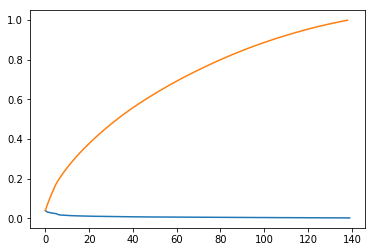

In [ ]:
"""
Generation Preprocessing (PCA, ec...)
"""

generate_music, create_music, create_random_music, pca_scores = generation_preprocessing(
    encoder,
    decoder,
    data = x_train+x_validation+x_test,
    BATCH_SIZE = 100)

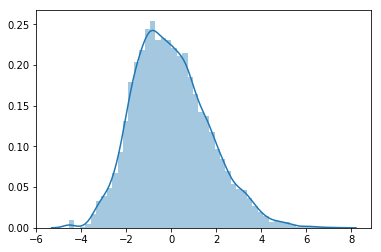

In [ ]:
"""
If you wanna see the PCs distribution
"""

#sns.distplot(pca_scores[:,0],)
#sns.distplot(pca_scores[:,2])
#sns.distplot(pca_scores[:,3])
#sns.distplot(pca_scores[:,120])

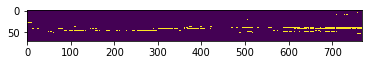

In [ ]:
"""
Generation
"""

create_random_music(threshold=0.2, pca = True, seed = 0)
#write_cutted_midi(generate_music([1,0.4,0.8,1,0.4,0.8]), "ciao")
#create_music([-2,0.1,1.3,0.4,-0.5,-0.123,0.23,0.1,0.36,-0.1, 0.01, 0.6, -0.3, 0.5, 5, -1,-1, 9, -1, 0.6,-0.6,0,0,2,0.5], threshold=0.1, pca = True)